In [1]:
import matplotlib.pyplot as plt
import cv2
import os, glob
import numpy as np

%matplotlib inline

# Pre-Processing

Loading Practice Images to np arrays

In [2]:
def load_images(folder_path):
    
    imgs = [plt.imread(path) for path in glob.glob(folder_path+'/*.jpg')]

    return imgs

In [4]:
imgs = load_images(os.getcwd()+ "/test_images")

# Helper Function
Function to easily display images in order to quickly view effect of various cv2 transformations

In [5]:
def display_images(img_array):
    
    cmap = None
    
    #set up dims of subplot arrangement
    rows = len(img_array)/3+1
    cols = 3
    
    #make each image visible
    plt.figure(figsize=(20, 20))
    
    #add each image to plot
    for i, img in enumerate(img_array):
        # use gray scale color map if there is only one channel
        cmap = 'gray' if len(img.shape)==2 else cmap
        
        plt.subplot(rows, cols, i+1)
        plt.imshow(img, cmap=cmap)
    
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()
        

Function to easily convert coler schemes for various images

In [6]:
def convert_imgs(imgs, color_space):
    new_imgs = []
    for img in imgs:
        new_imgs.append(cv2.cvtColor(img, color_space))
        
    return new_imgs

# Convert to HLS For Easier Color Distinction

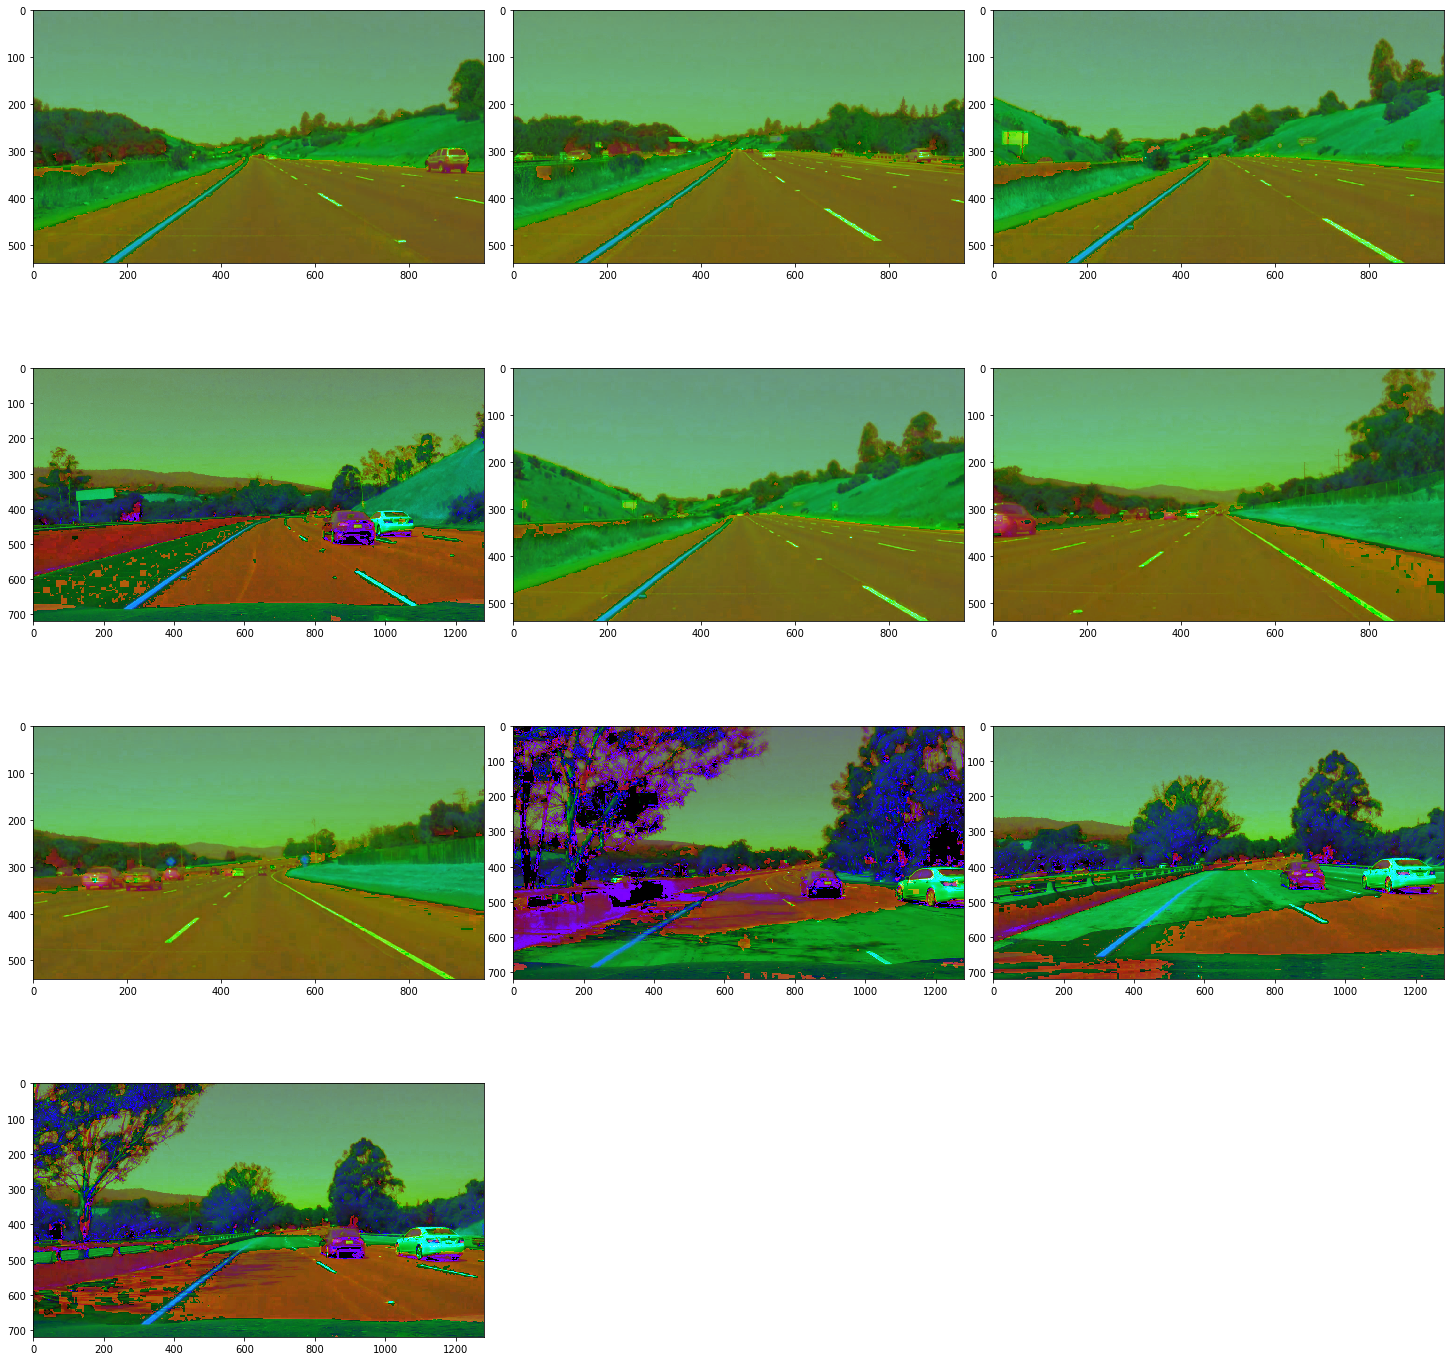

In [7]:
hls_imgs = convert_imgs(imgs, cv2.COLOR_RGB2HLS)
display_images(hls_imgs)

# Filter out While/Yellow 

reference: http://www.standardista.com/css3/cssnamed-hsl-and-rgb-colors/


## Function to to Mask from HLS IMG
White has a broad range for hue and saturation and is limited by its light value

Yellow lanes have a low hue value and a higher light and saturation value

In [8]:
def get_mask(img):
    
    # white mask- experiment a bit with vals
    lower = np.uint8([  0, 220,   0])
    upper = np.uint8([255, 255, 255])
    w_mask = cv2.inRange(img, lower, upper)
    
    #yellow mask- experiment a bit with vals
    lower = np.uint8([15, 127, 127])
    upper = np.uint8([25, 255, 255])
    y_mask = cv2.inRange(img, lower, upper)
    
    #combine the 2 masks
    final_mask = cv2.bitwise_or(w_mask, y_mask)
    
    return final_mask
    
    
    
    

# Function to filter original Image

Converts to HLS to get the mask, then filters the original image

In [9]:
def filter_white_yellow(imgs):
    filtered_imgs = []
    #get hls imgs
    hls_imgs = convert_imgs(imgs, cv2.COLOR_RGB2HLS)
    
    for hls_img, img in zip(hls_imgs, imgs):
        mask = get_mask(hls_img)
        
        filtered_imgs.append(cv2.bitwise_and(img, img, mask = mask))
        
    
    return filtered_imgs
    
    

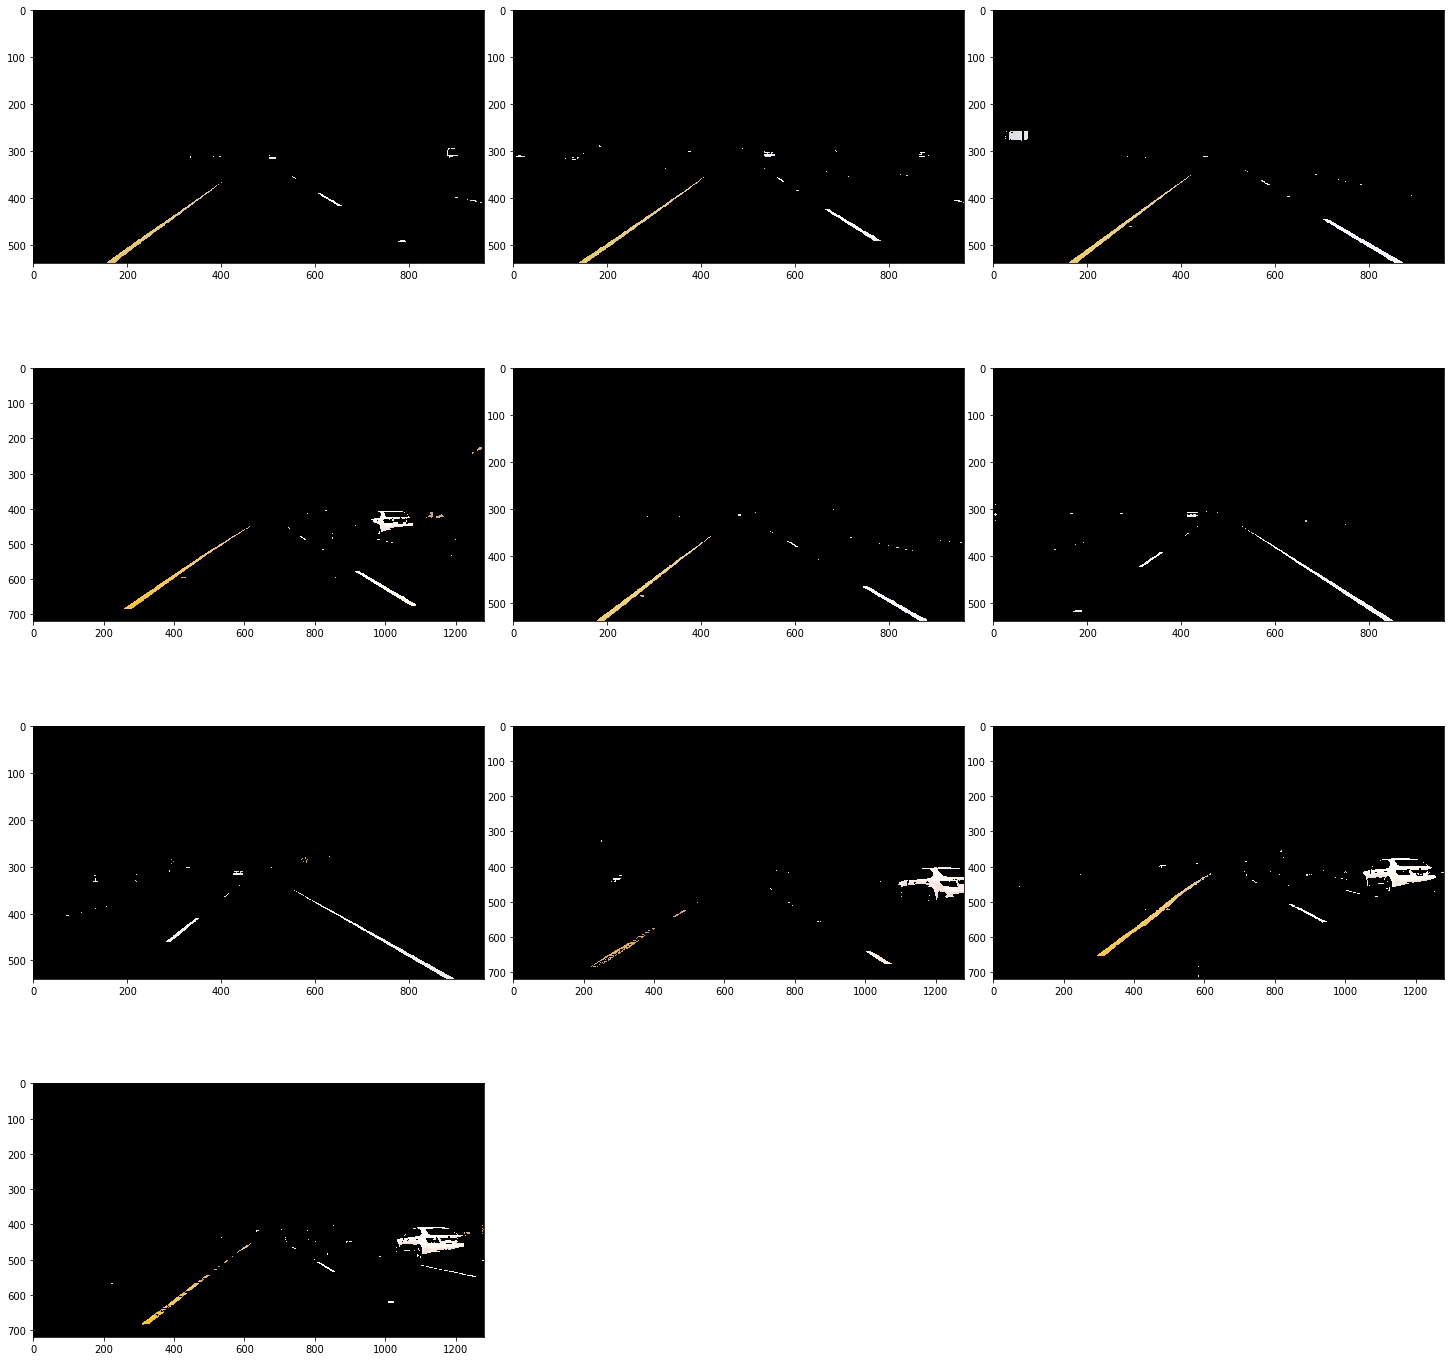

In [10]:
filtered_imgs = filter_white_yellow(imgs)    
display_images(filtered_imgs)

# Find Straight Lines

Use the edge detector to find straight lines:

To improve performance, it's pretty standard to convert to gray scale to make the edge detector run faster, and to run a gaussian blur in order to remove arbitrary edges

## PreProccessing Function
Takes an array of images and returns the array with its images having been 

In [11]:
def gray_and_blur(img, k_size=13):
    
    #convert to grayscale
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    #blur image
    img = cv2.GaussianBlur(img, (k_size, k_size), 0)
    
    return img

def pre_edge(imgs, k_size=13):
    processed = []
    
    for img in imgs:
        
        processed.append(gray_and_blur(img, k_size))
        
    return processed

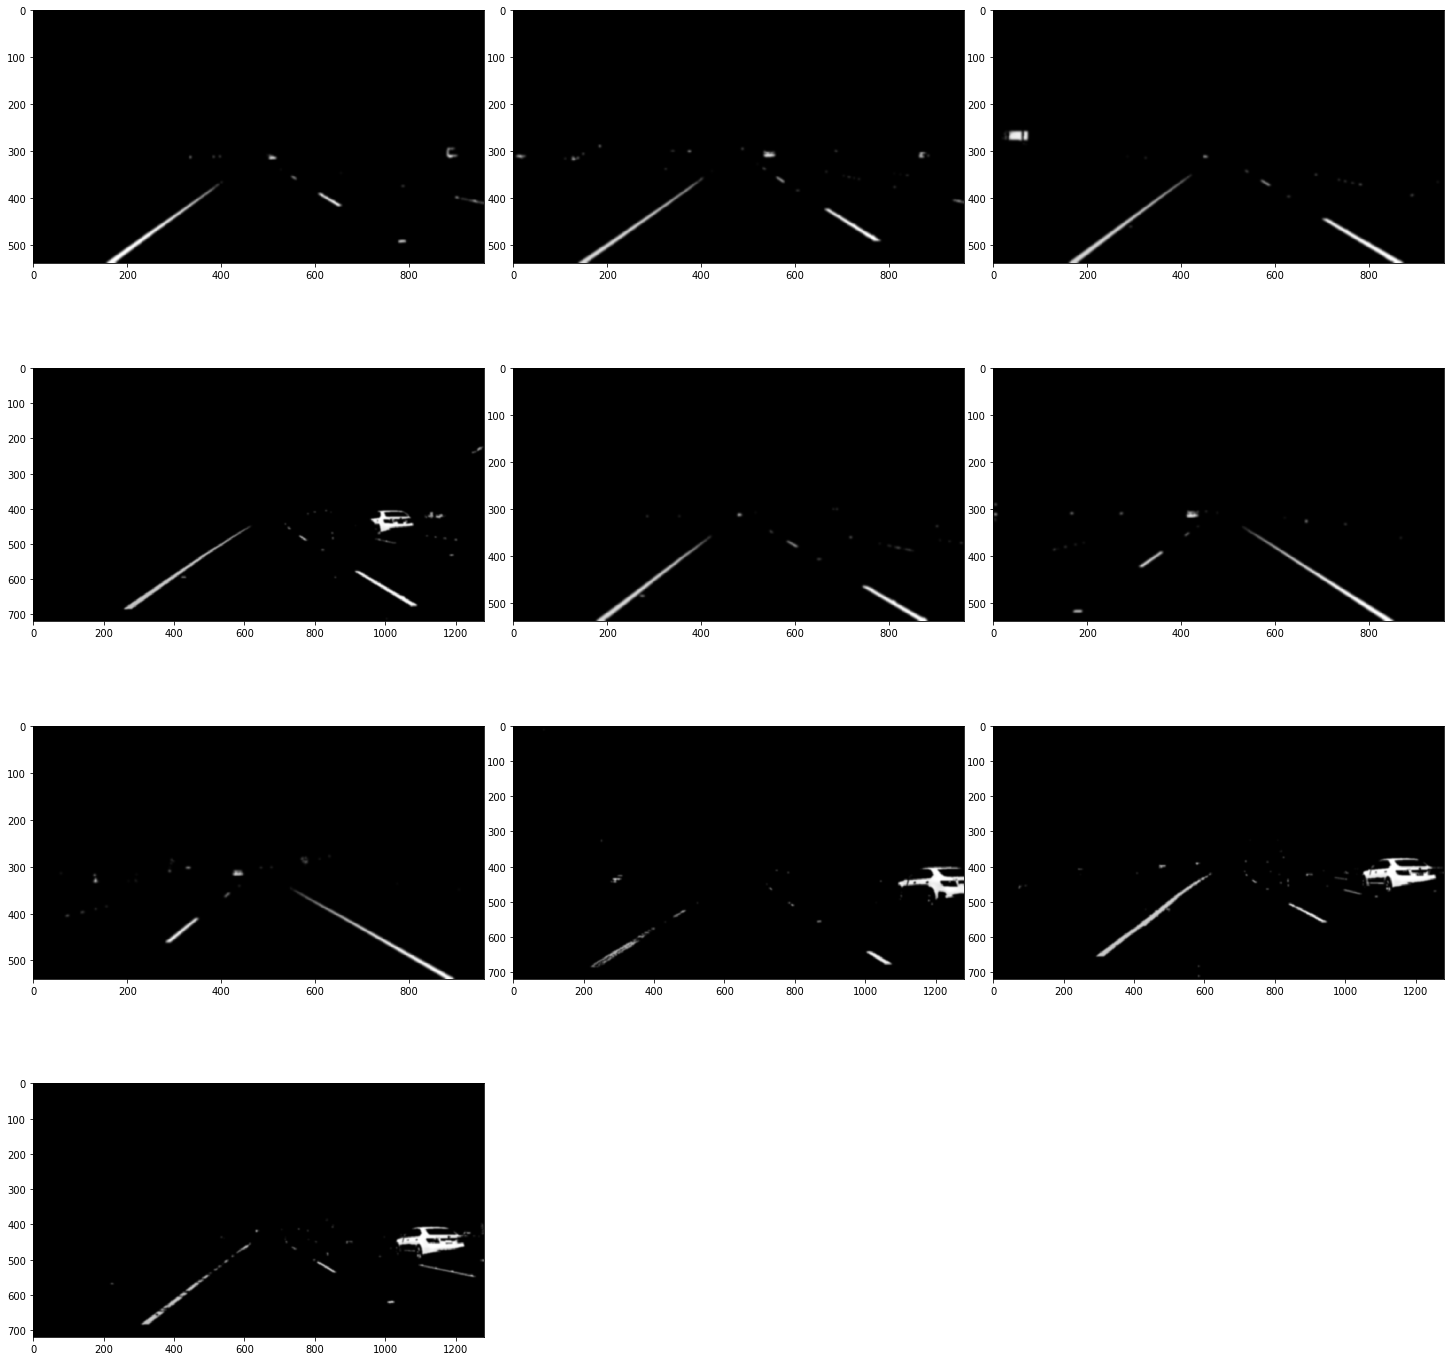

In [12]:
processed = pre_edge(filtered_imgs)
display_images(processed)

# Get Edges

Further filter the images by ussing Canny edge finder to get only edges within the function

The edge finder takes in an image, a lower threshold and an upper threshold-- if a pixel's gradient is greater than the upper threshold, it is acccepted as an edge. If the gradient is lower than the lower threshold, it is automatically rejected. If the pixel's gradient is between the two thresholds, it is accepted only if it is connected to an accepted edge

In [13]:
def get_edges(imgs, low_t=40, high_t=120, k_size=17):
    edged = []
    #process images
    processed = pre_edge(imgs, k_size=k_size)
    
    for img in processed:
        edged.append(cv2.Canny(img, low_t, high_t))
        
    return edged
    

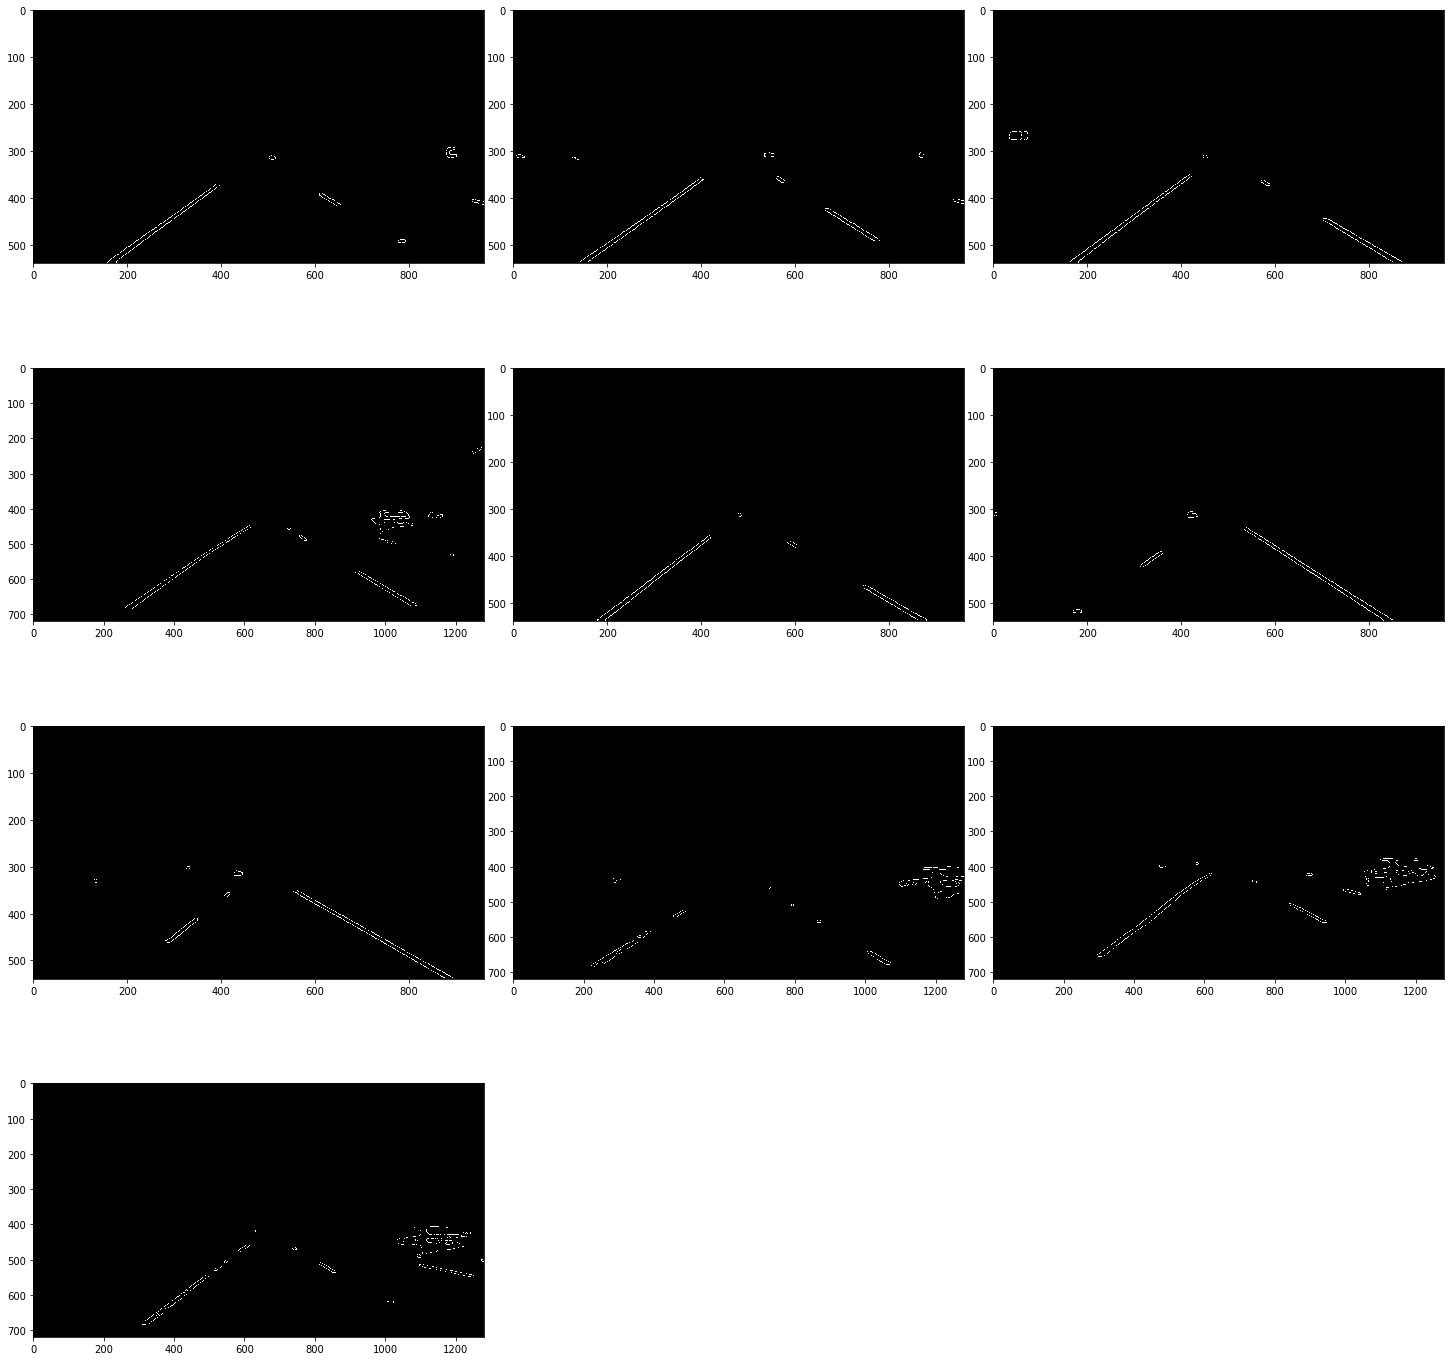

In [14]:
edged = get_edges(filtered_imgs)
display_images(edged)

# Get  straight lines within the image

Get the lines using a Hough Line Transfrom- a lot of different values to tinker with

Then draw the lines

In [15]:
def get_lines(img, rho=1, theta=np.pi/180, threshold=30, minLineLength=20, max_Line_Gap=300):
    
    lines = cv2.HoughLinesP(img, rho=rho, theta=theta,
                           threshold=threshold, minLineLength=minLineLength, 
                           maxLineGap=max_Line_Gap)
    lines = lines.tolist()
    
    return lines      
        

In [16]:
def draw_lines(img, lines):
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), [255, 0, 0], thickness=2)
            
    return img
    
                
            
def line_images(original_imgs, processed_imgs):
    lines = []
    final_images = []
    
    #get lines
    for img in processed_imgs:
        lines.append(get_lines(img))
        
    
    #draw lines
    for img, line in zip(original_imgs, lines):
        final_images.append(draw_lines(img, line))
        
    return final_images

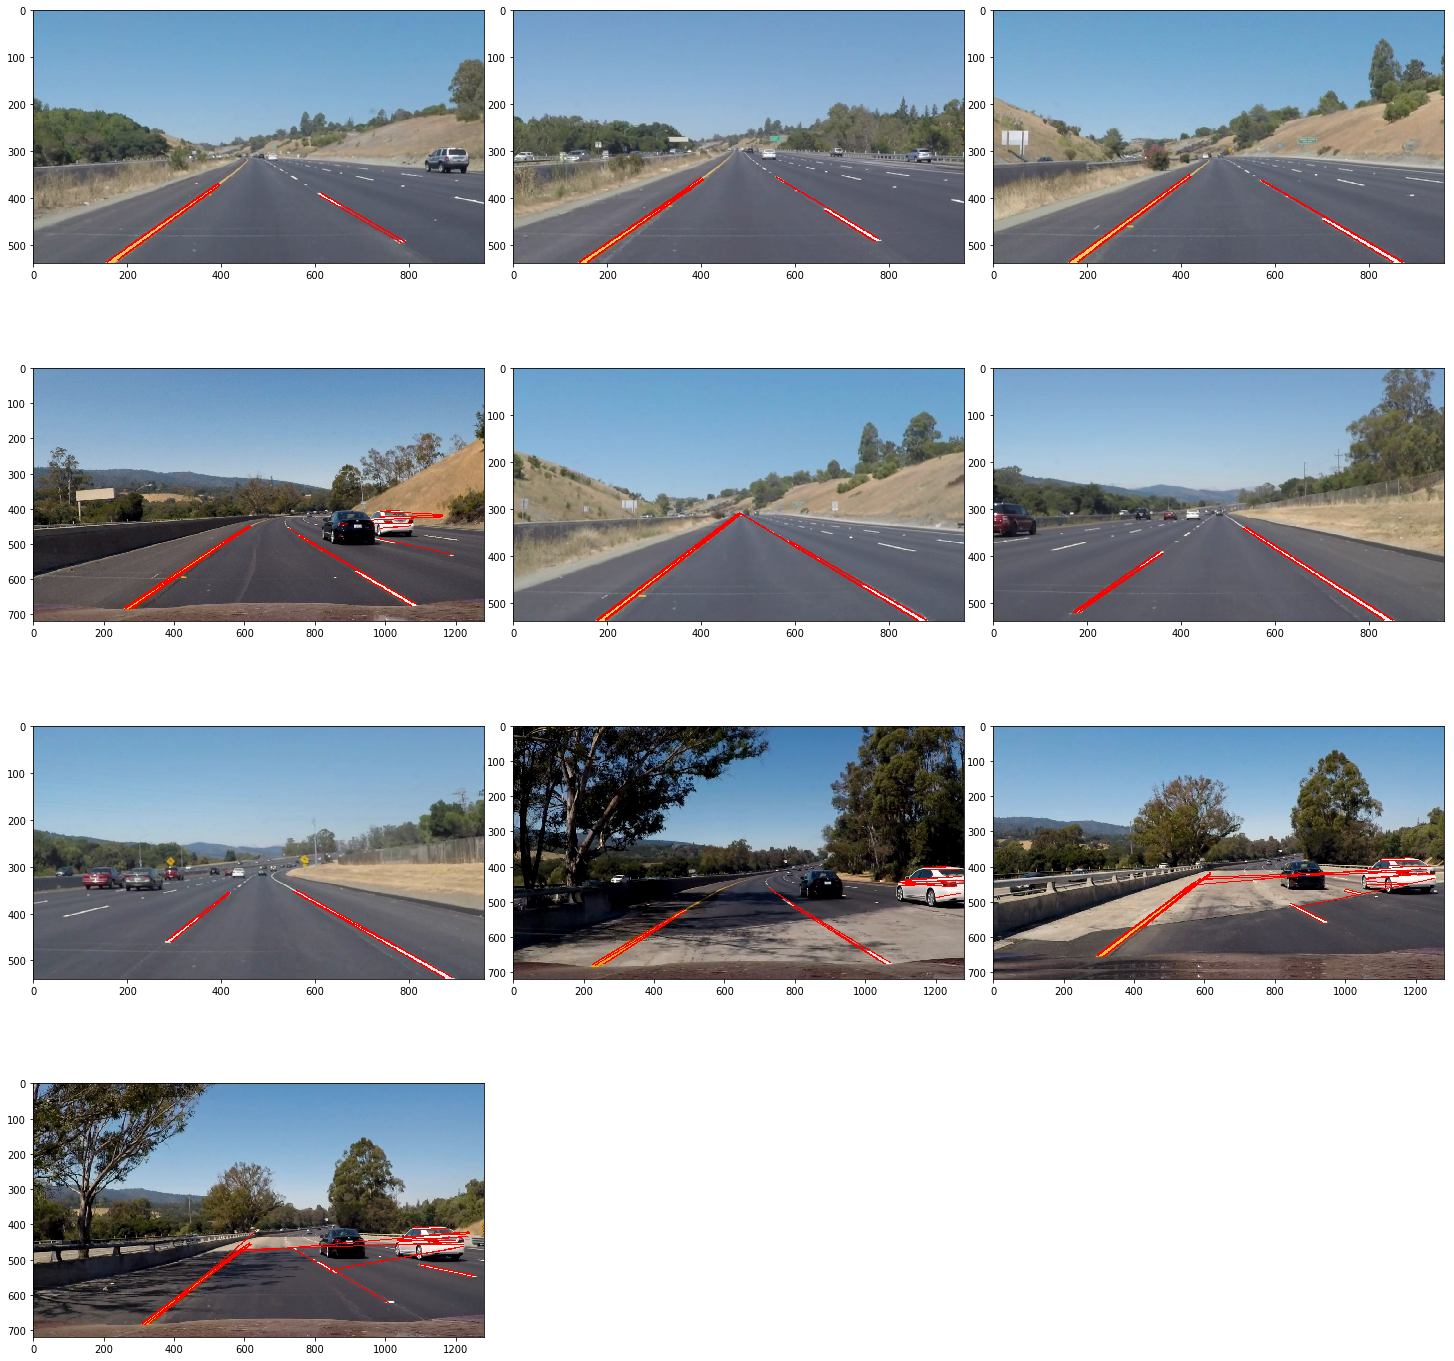

In [17]:
final = line_images(imgs, edged)
display_images(final)

# Not Great

So we are picking up the lines correctly: the problem is, we are also picking up a lot of other stuff. After trying a number of other methods, the best way I found to solve the issue is by creating a porportional region where it is reasonable to expect lane lines to arise

# Limiting Lane Region Functions

In [33]:
def mask_region(image, vertices):
    #fill in the mask based on vertices 
    mask = np.zeros_like(image)
    cv2.fillPoly(mask, vertices, 255)       

    return cv2.bitwise_and(image, mask)

def get_region(image):
    """
    Create a quadrilateral area to limit the region
    based on an reasonable estimate of where lanes
    lines should be
    """
    # create porportional boundary
    rows, cols = image.shape[:2]
    
    bottom_left  = [cols*0.1, rows*0.95]
    top_left     = [cols*0.4, rows*0.55]
    bottom_right = [cols*0.9, rows*0.95]
    top_right    = [cols*0.6, rows*0.55] 
    
    # the vertices are an array of polygons (i.e array of arrays) and the data type must be integer
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    return mask_region(image, vertices)



def limit_region(images):
    new_images = []
    
    for img in images:
        new_images.append(get_region(img))
        
    return new_images

In [34]:
limited = limit_region(edged)

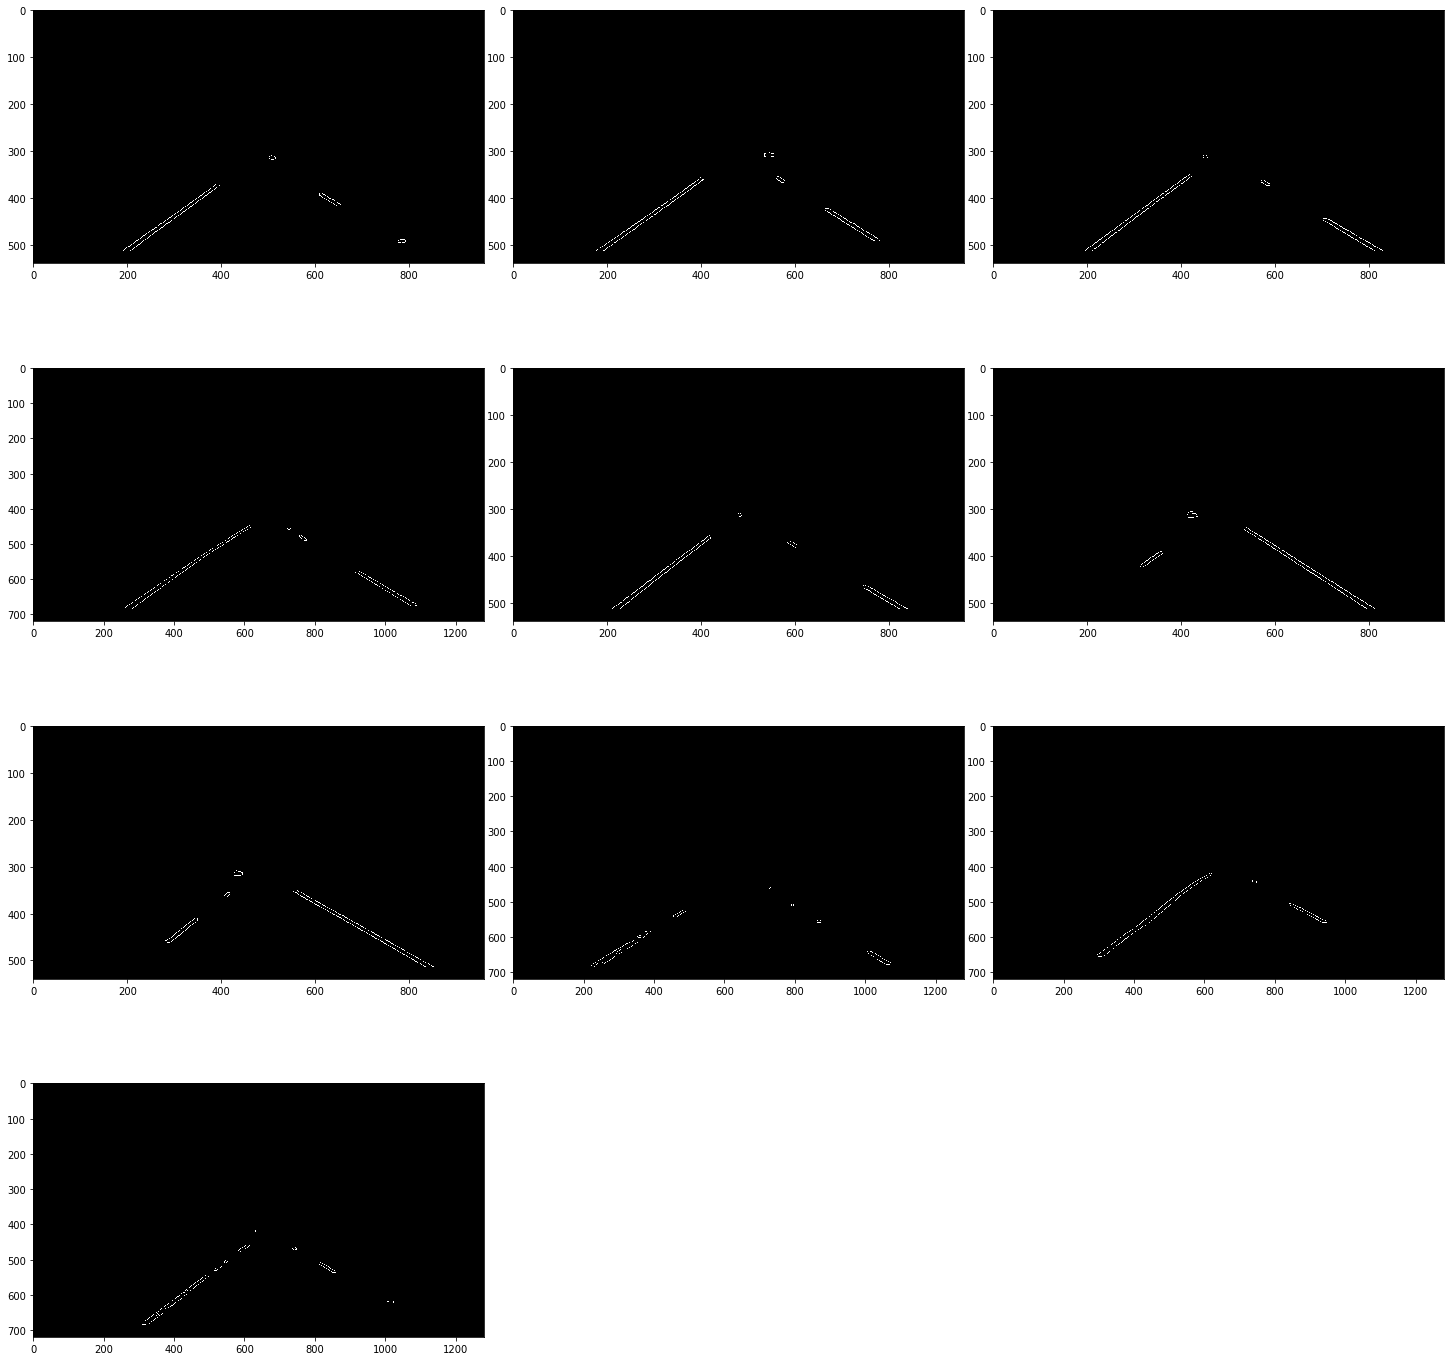

In [35]:
display_images(limited)

# Final Function to Run Entire Process at Once

In [36]:
def get_lane_lines(imgs):

    filtered_imgs = filter_white_yellow(imgs)
    edged = get_edges(filtered_imgs)
    limited = limit_region(edged)
    
    final = line_images(imgs, limited)
    
    display_images(final)
    
    return final
    
    

# Reload Images and Run Final Result

In [37]:
imgs = load_images(os.getcwd()+ "/test_images")

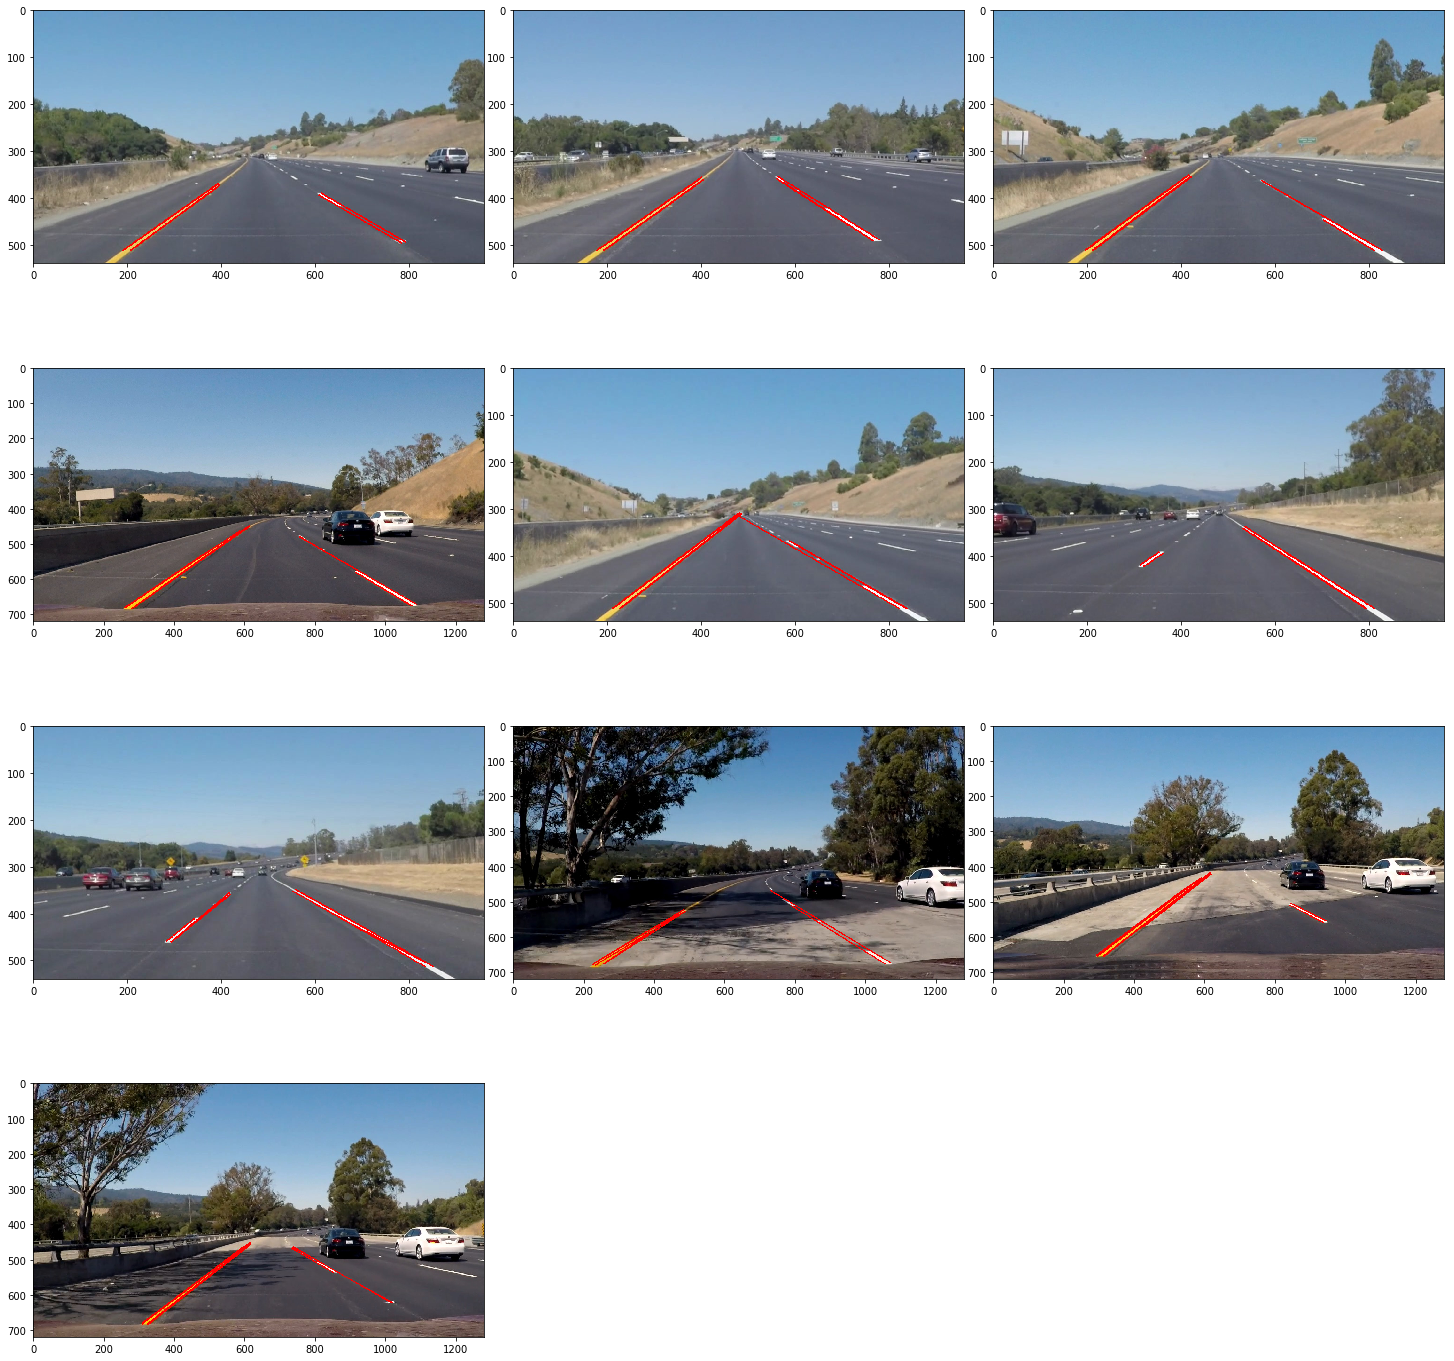

In [38]:
result = get_lane_lines(imgs)